In [4]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)
batch_size = 64
num_branches = 10
num_trunk_epochs = 120000
lr = 1e-5
num_LBFGS_epochs = 10000

print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")

W0000 00:00:1762395619.467389   13253 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1762395619.522835   13253 service.cc:145] XLA service 0x30f8cf320 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762395619.523002   13253 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1762395619.525271   13253 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1762395619.525282   13253 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



In [5]:
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

In [6]:
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
x_grid = jnp.array(dataset['x'])
data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data])

n_samp = len(data)
train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.33, random_state = seed)
u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])


In [7]:
xx, tt = jnp.meshgrid(x_grid,t_grid)
xt_grid = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1)
print(xt_grid.shape)

ss_grid = s_train.reshape([-1, 40401]).T # solutions
print(ss_grid.shape)

(40401, 2)
(40401, 295)


In [8]:
u_dim = 2 # in this case, two 
y_dim = 2 # (x,t)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_branches] 
trunk_arch  = [y_dim, 40, 40, num_branches] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (num_branches, s_train.shape[0]))

model = trunk_model, A_model

def deeponet_step1(model, u_tr):
    trunk_model, A_model = model
    trunk_mat = jax.vmap(trunk_model)(u_tr)
    return (trunk_mat @ A_model)

def loss_fn(model, u, s):
    pred_y = deeponet_step1(model,u)
    return jnp.mean((s - pred_y) ** 2) # sum of squared - to match svd interp

In [9]:
# equinox training step 
"""
@eqx.filter_jit
def train_step(model, opt_state, x, y, opt_update):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y) # get loss and gradients
    updates, opt_state = opt_update(grads, opt_state, model) # update step
    model = eqx.apply_updates(model, updates) # apply updates
    return model, opt_state, loss
"""
@eqx.filter_jit
def train_step(model, opt_state, x, y):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


In [10]:
"""optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

trunk_train_hist, trunk_test_hist = [],[]

print("beginning trunk training...")
for epoch in tqdm(range(num_trunk_epochs)):
    
    model, opt_state, loss = train_step(model, opt_state, xt_grid, ss_grid, optim.update)

    trunk_train_hist.append(float(loss))

save_path = "deeponet_trunk_model.eqx"
A_save_path = "A_model.npy"

eqx.tree_serialise_leaves(save_path, trunk_model)
np.save(A_save_path, np.array(A_model))

print(f"Saved trunk model to {save_path}")
print(f"Saved A_model to {A_save_path}")
"""

# 1. Pretrain with Adam
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []

@eqx.filter_jit
def train_step(model, opt_state, batch):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, *batch)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

for step in tqdm(range(num_trunk_epochs)):
    model, opt_state, loss = train_step(model, opt_state, (xt_grid, ss_grid))
    loss_hist.append(float(loss))
    if step % 1000 == 0:
        print(f"Adam step {step}: loss={float(loss):.3e}")

print("final adam loss:", loss)

opt = optax.lbfgs()

for step in tqdm(range(num_LBFGS_epochs)):
    model, opt_state, loss = train_step(model, opt_state, (xt_grid, ss_grid))
    loss_hist.append(float(loss))
    if step % 1000 == 0:
        print(f"LBFGS step {step}: loss={float(loss):.3e}")


  0%|          | 8/120000 [00:00<52:52, 37.82it/s]  

Adam step 0: loss=7.433e+00


  1%|          | 1012/120000 [00:14<29:00, 68.36it/s]

Adam step 1000: loss=3.098e+00


  2%|▏         | 2012/120000 [00:29<34:44, 56.61it/s]

Adam step 2000: loss=1.359e+00


  3%|▎         | 3007/120000 [00:45<28:08, 69.30it/s]

Adam step 3000: loss=6.331e-01


  3%|▎         | 4010/120000 [01:00<28:55, 66.82it/s]

Adam step 4000: loss=3.513e-01


  4%|▍         | 5006/120000 [01:16<40:18, 47.54it/s]

Adam step 5000: loss=2.395e-01


  5%|▌         | 6011/120000 [01:33<28:51, 65.82it/s]  

Adam step 6000: loss=1.983e-01


  6%|▌         | 7007/120000 [01:49<30:13, 62.32it/s]

Adam step 7000: loss=1.803e-01


  7%|▋         | 8012/120000 [02:05<27:13, 68.56it/s]

Adam step 8000: loss=1.704e-01


  8%|▊         | 9011/120000 [02:21<29:41, 62.30it/s]

Adam step 9000: loss=1.639e-01


  8%|▊         | 10012/120000 [02:36<30:17, 60.51it/s]

Adam step 10000: loss=1.588e-01


  9%|▉         | 11014/120000 [02:52<27:23, 66.31it/s]

Adam step 11000: loss=1.547e-01


 10%|█         | 12012/120000 [03:07<29:36, 60.78it/s]

Adam step 12000: loss=1.511e-01


 11%|█         | 13013/120000 [03:23<26:34, 67.09it/s]

Adam step 13000: loss=1.478e-01


 12%|█▏        | 14010/120000 [03:38<25:00, 70.62it/s]

Adam step 14000: loss=1.445e-01


 13%|█▎        | 15011/120000 [03:54<27:40, 63.22it/s]

Adam step 15000: loss=1.411e-01


 13%|█▎        | 16010/120000 [04:10<24:40, 70.25it/s]

Adam step 16000: loss=1.377e-01


 14%|█▍        | 17011/120000 [04:25<28:21, 60.54it/s]

Adam step 17000: loss=1.343e-01


 15%|█▌        | 18014/120000 [04:42<24:05, 70.56it/s]

Adam step 18000: loss=1.308e-01


 16%|█▌        | 19010/120000 [04:57<26:14, 64.16it/s]

Adam step 19000: loss=1.272e-01


 17%|█▋        | 20009/120000 [05:12<25:57, 64.18it/s]

Adam step 20000: loss=1.236e-01


 18%|█▊        | 21013/120000 [05:28<24:55, 66.19it/s]

Adam step 21000: loss=1.199e-01


 18%|█▊        | 22008/120000 [05:44<26:05, 62.58it/s]

Adam step 22000: loss=1.161e-01


 19%|█▉        | 23012/120000 [05:59<23:18, 69.35it/s]

Adam step 23000: loss=1.122e-01


 20%|██        | 24010/120000 [06:15<27:25, 58.34it/s]

Adam step 24000: loss=1.083e-01


 21%|██        | 25012/120000 [06:31<22:51, 69.25it/s]

Adam step 25000: loss=1.044e-01


 22%|██▏       | 26007/120000 [06:46<25:01, 62.60it/s]

Adam step 26000: loss=1.005e-01


 23%|██▎       | 27014/120000 [07:02<22:07, 70.03it/s]

Adam step 27000: loss=9.667e-02


 23%|██▎       | 28008/120000 [07:17<24:13, 63.27it/s]

Adam step 28000: loss=9.282e-02


 24%|██▍       | 29009/120000 [07:33<24:01, 63.14it/s]

Adam step 29000: loss=8.900e-02


 25%|██▌       | 30009/120000 [07:48<23:47, 63.04it/s]

Adam step 30000: loss=8.522e-02


 26%|██▌       | 31010/120000 [08:04<26:41, 55.57it/s]

Adam step 31000: loss=8.149e-02


 27%|██▋       | 32012/120000 [08:19<22:46, 64.38it/s]

Adam step 32000: loss=7.782e-02


 28%|██▊       | 33013/120000 [08:35<23:39, 61.28it/s]

Adam step 33000: loss=7.423e-02


 28%|██▊       | 34013/120000 [08:50<21:30, 66.64it/s]

Adam step 34000: loss=7.070e-02


 29%|██▉       | 35008/120000 [09:05<20:05, 70.50it/s]

Adam step 35000: loss=6.725e-02


 30%|███       | 36008/120000 [09:20<23:04, 60.65it/s]

Adam step 36000: loss=6.388e-02


 31%|███       | 37008/120000 [09:35<19:43, 70.10it/s]

Adam step 37000: loss=6.059e-02


 32%|███▏      | 38009/120000 [09:50<21:45, 62.80it/s]

Adam step 38000: loss=5.739e-02


 33%|███▎      | 39010/120000 [10:05<21:42, 62.20it/s]

Adam step 39000: loss=5.428e-02


 33%|███▎      | 40014/120000 [10:21<20:04, 66.38it/s]

Adam step 40000: loss=5.125e-02


 34%|███▍      | 41011/120000 [10:36<19:01, 69.17it/s]

Adam step 41000: loss=4.830e-02


 35%|███▌      | 42012/120000 [10:52<20:14, 64.20it/s]

Adam step 42000: loss=4.543e-02


 36%|███▌      | 43011/120000 [11:07<21:01, 61.02it/s]

Adam step 43000: loss=4.264e-02


 37%|███▋      | 44010/120000 [11:23<18:43, 67.61it/s]

Adam step 44000: loss=3.994e-02


 38%|███▊      | 45007/120000 [11:38<18:44, 66.69it/s]

Adam step 45000: loss=3.732e-02


 38%|███▊      | 46008/120000 [11:53<18:30, 66.61it/s]

Adam step 46000: loss=3.479e-02


 39%|███▉      | 47007/120000 [12:09<17:51, 68.10it/s]

Adam step 47000: loss=3.235e-02


 40%|████      | 48010/120000 [12:24<19:09, 62.65it/s]

Adam step 48000: loss=3.001e-02


 41%|████      | 49013/120000 [12:40<17:37, 67.15it/s]

Adam step 49000: loss=2.775e-02


 42%|████▏     | 50008/120000 [12:55<16:47, 69.47it/s]

Adam step 50000: loss=2.560e-02


 43%|████▎     | 51008/120000 [13:11<18:58, 60.57it/s]

Adam step 51000: loss=2.355e-02


 43%|████▎     | 52010/120000 [13:26<16:11, 69.99it/s]

Adam step 52000: loss=2.161e-02


 44%|████▍     | 53012/120000 [13:41<16:58, 65.75it/s]

Adam step 53000: loss=1.978e-02


 45%|████▌     | 54014/120000 [13:57<16:20, 67.31it/s]

Adam step 54000: loss=1.805e-02


 46%|████▌     | 55013/120000 [14:12<16:35, 65.29it/s]

Adam step 55000: loss=1.644e-02


 47%|████▋     | 56014/120000 [14:28<15:37, 68.23it/s]

Adam step 56000: loss=1.492e-02


 48%|████▊     | 57012/120000 [14:43<17:31, 59.91it/s]

Adam step 57000: loss=1.351e-02


 48%|████▊     | 58010/120000 [14:59<15:00, 68.83it/s]

Adam step 58000: loss=1.219e-02


 49%|████▉     | 59013/120000 [15:15<15:50, 64.15it/s]

Adam step 59000: loss=1.096e-02


 50%|█████     | 60014/120000 [15:31<14:31, 68.80it/s]

Adam step 60000: loss=9.820e-03


 51%|█████     | 61014/120000 [15:46<14:44, 66.72it/s]

Adam step 61000: loss=8.779e-03


 52%|█████▏    | 62014/120000 [16:01<14:15, 67.80it/s]

Adam step 62000: loss=7.833e-03


 53%|█████▎    | 63010/120000 [16:16<14:33, 65.23it/s]

Adam step 63000: loss=6.975e-03


 53%|█████▎    | 64009/120000 [16:32<13:18, 70.13it/s]

Adam step 64000: loss=6.200e-03


 54%|█████▍    | 65005/120000 [16:47<18:50, 48.63it/s]

Adam step 65000: loss=5.501e-03


 55%|█████▌    | 66009/120000 [17:04<14:45, 61.00it/s]

Adam step 66000: loss=4.871e-03


 56%|█████▌    | 67007/120000 [17:19<13:08, 67.23it/s]

Adam step 67000: loss=4.302e-03


 57%|█████▋    | 68007/120000 [17:34<13:19, 65.01it/s]

Adam step 68000: loss=3.786e-03


 58%|█████▊    | 69008/120000 [17:49<12:57, 65.56it/s]

Adam step 69000: loss=3.318e-03


 58%|█████▊    | 70015/120000 [18:04<11:49, 70.42it/s]

Adam step 70000: loss=2.895e-03


 59%|█████▉    | 71013/120000 [18:19<11:50, 68.93it/s]

Adam step 71000: loss=2.514e-03


 60%|██████    | 72015/120000 [18:34<12:13, 65.43it/s]

Adam step 72000: loss=2.171e-03


 61%|██████    | 73008/120000 [18:50<11:05, 70.56it/s]

Adam step 73000: loss=1.861e-03


 62%|██████▏   | 74013/120000 [19:04<10:58, 69.88it/s]

Adam step 74000: loss=1.581e-03


 63%|██████▎   | 75012/120000 [19:20<11:58, 62.58it/s]

Adam step 75000: loss=1.332e-03


 63%|██████▎   | 76013/120000 [19:35<10:29, 69.93it/s]

Adam step 76000: loss=1.112e-03


 64%|██████▍   | 77010/120000 [19:50<11:54, 60.20it/s]

Adam step 77000: loss=9.200e-04


 65%|██████▌   | 78010/120000 [20:05<09:59, 70.05it/s]

Adam step 78000: loss=7.545e-04


 66%|██████▌   | 79010/120000 [20:20<10:16, 66.45it/s]

Adam step 79000: loss=6.136e-04


 67%|██████▋   | 80011/120000 [20:35<09:41, 68.78it/s]

Adam step 80000: loss=4.950e-04


 68%|██████▊   | 81012/120000 [20:51<09:33, 68.04it/s]

Adam step 81000: loss=3.979e-04


 68%|██████▊   | 82010/120000 [21:06<09:50, 64.37it/s]

Adam step 82000: loss=3.214e-04


 69%|██████▉   | 83008/120000 [21:21<09:23, 65.61it/s]

Adam step 83000: loss=2.642e-04


 70%|███████   | 84007/120000 [21:36<08:26, 70.99it/s]

Adam step 84000: loss=2.242e-04


 71%|███████   | 85012/120000 [21:52<08:37, 67.58it/s]

Adam step 85000: loss=1.989e-04


 72%|███████▏  | 86012/120000 [22:06<07:51, 72.12it/s]

Adam step 86000: loss=1.850e-04


 73%|███████▎  | 87013/120000 [22:22<09:03, 60.66it/s]

Adam step 87000: loss=1.786e-04


 73%|███████▎  | 88007/120000 [22:38<08:11, 65.04it/s]

Adam step 88000: loss=1.755e-04


 74%|███████▍  | 89008/120000 [22:54<07:37, 67.69it/s]

Adam step 89000: loss=1.732e-04


 75%|███████▌  | 90011/120000 [23:10<08:15, 60.54it/s]

Adam step 90000: loss=1.709e-04


 76%|███████▌  | 91008/120000 [23:25<06:49, 70.80it/s]

Adam step 91000: loss=1.685e-04


 77%|███████▋  | 92008/120000 [23:40<07:43, 60.41it/s]

Adam step 92000: loss=1.661e-04


 78%|███████▊  | 93011/120000 [23:56<07:04, 63.56it/s]

Adam step 93000: loss=1.637e-04


 78%|███████▊  | 94013/120000 [24:11<07:01, 61.67it/s]

Adam step 94000: loss=1.612e-04


 79%|███████▉  | 95011/120000 [24:27<06:38, 62.65it/s]

Adam step 95000: loss=1.587e-04


 80%|████████  | 96014/120000 [24:43<06:03, 66.04it/s]

Adam step 96000: loss=1.562e-04


 81%|████████  | 97013/120000 [24:59<06:09, 62.18it/s]

Adam step 97000: loss=1.536e-04


 82%|████████▏ | 98011/120000 [25:15<05:50, 62.79it/s]

Adam step 98000: loss=1.510e-04


 83%|████████▎ | 99012/120000 [25:30<05:00, 69.92it/s]

Adam step 99000: loss=1.484e-04


 83%|████████▎ | 100010/120000 [25:46<05:30, 60.47it/s]

Adam step 100000: loss=1.458e-04


 84%|████████▍ | 101007/120000 [26:01<04:46, 66.19it/s]

Adam step 101000: loss=1.431e-04


 85%|████████▌ | 102013/120000 [26:17<04:24, 68.06it/s]

Adam step 102000: loss=1.404e-04


 86%|████████▌ | 103011/120000 [26:33<04:38, 60.94it/s]

Adam step 103000: loss=1.377e-04


 87%|████████▋ | 104014/120000 [26:49<03:52, 68.84it/s]

Adam step 104000: loss=1.350e-04


 88%|████████▊ | 105011/120000 [27:04<04:08, 60.24it/s]

Adam step 105000: loss=1.323e-04


 88%|████████▊ | 106011/120000 [27:20<03:21, 69.38it/s]

Adam step 106000: loss=1.296e-04


 89%|████████▉ | 107009/120000 [27:36<03:34, 60.50it/s]

Adam step 107000: loss=1.269e-04


 90%|█████████ | 108012/120000 [27:51<03:18, 60.47it/s]

Adam step 108000: loss=1.242e-04


 91%|█████████ | 109010/120000 [28:07<02:51, 64.10it/s]

Adam step 109000: loss=1.215e-04


 92%|█████████▏| 110012/120000 [28:23<02:28, 67.48it/s]

Adam step 110000: loss=1.188e-04


 93%|█████████▎| 111009/120000 [28:37<02:26, 61.31it/s]

Adam step 111000: loss=1.162e-04


 93%|█████████▎| 112010/120000 [28:53<02:07, 62.51it/s]

Adam step 112000: loss=1.135e-04


 94%|█████████▍| 113008/120000 [29:08<01:58, 59.15it/s]

Adam step 113000: loss=1.109e-04


 95%|█████████▌| 114012/120000 [29:24<01:39, 59.98it/s]

Adam step 114000: loss=1.084e-04


 96%|█████████▌| 115011/120000 [29:40<01:11, 69.34it/s]

Adam step 115000: loss=1.058e-04


 97%|█████████▋| 116008/120000 [29:56<01:01, 65.22it/s]

Adam step 116000: loss=1.033e-04


 98%|█████████▊| 117009/120000 [30:12<00:47, 62.97it/s]

Adam step 117000: loss=1.008e-04


 98%|█████████▊| 118005/120000 [30:28<00:31, 62.65it/s]

Adam step 118000: loss=9.835e-05


 99%|█████████▉| 119012/120000 [30:43<00:15, 63.18it/s]

Adam step 119000: loss=9.595e-05


100%|██████████| 120000/120000 [30:59<00:00, 64.52it/s]


final adam loss: 9.35777e-05


  0%|          | 7/10000 [00:00<02:30, 66.58it/s]

LBFGS step 0: loss=9.358e-05


 10%|█         | 1011/10000 [00:16<02:17, 65.56it/s]

LBFGS step 1000: loss=9.124e-05


 20%|██        | 2014/10000 [00:31<02:03, 64.62it/s]

LBFGS step 2000: loss=8.895e-05


 30%|███       | 3012/10000 [00:47<01:42, 68.02it/s]

LBFGS step 3000: loss=8.670e-05


 40%|████      | 4008/10000 [01:04<01:34, 63.22it/s]

LBFGS step 4000: loss=8.449e-05


 50%|█████     | 5009/10000 [01:20<01:25, 58.06it/s]

LBFGS step 5000: loss=8.231e-05


 60%|██████    | 6011/10000 [01:36<01:00, 65.83it/s]

LBFGS step 6000: loss=8.017e-05


 70%|███████   | 7007/10000 [01:52<00:54, 54.46it/s]

LBFGS step 7000: loss=7.808e-05


 80%|████████  | 8008/10000 [02:08<00:29, 67.32it/s]

LBFGS step 8000: loss=7.604e-05


 90%|█████████ | 9013/10000 [02:24<00:14, 68.28it/s]

LBFGS step 9000: loss=7.404e-05


100%|██████████| 10000/10000 [02:40<00:00, 62.48it/s]


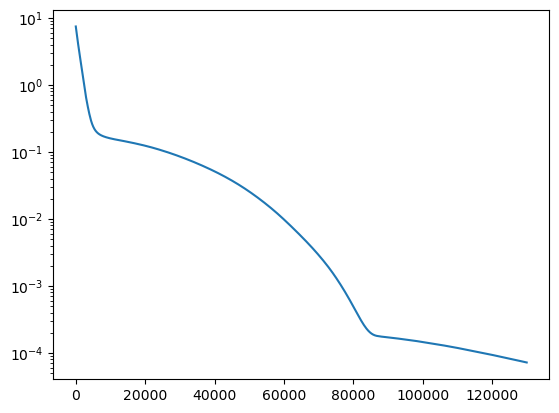

In [52]:
plt.plot(loss_hist)
plt.yscale('log')

In [11]:
# Evaluate final loss on training data
final_loss = float(loss_fn(model, xt_grid, ss_grid))
print(f"\nFinal training loss after L-BFGS: {final_loss:.6e}")



Final training loss after L-BFGS: 7.207674e-05


In [12]:
trunk_mat = np.array(jax.vmap(trunk_model)(xt_grid)) # this is against the entire flattened xt grid - not at fixed time t
Q,R = scipy.linalg.qr(trunk_mat, mode = 'economic')
T = scipy.linalg.inv(R.T)


In [13]:
xx, tt = jnp.meshgrid(x_grid,t_grid[-1:])
xt_grid_at_i = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1)

In [14]:
trunk_mat_at_i = np.array(jax.vmap(trunk_model)(xt_grid_at_i))
Q,R = scipy.linalg.qr(trunk_mat_at_i, mode = 'economic')

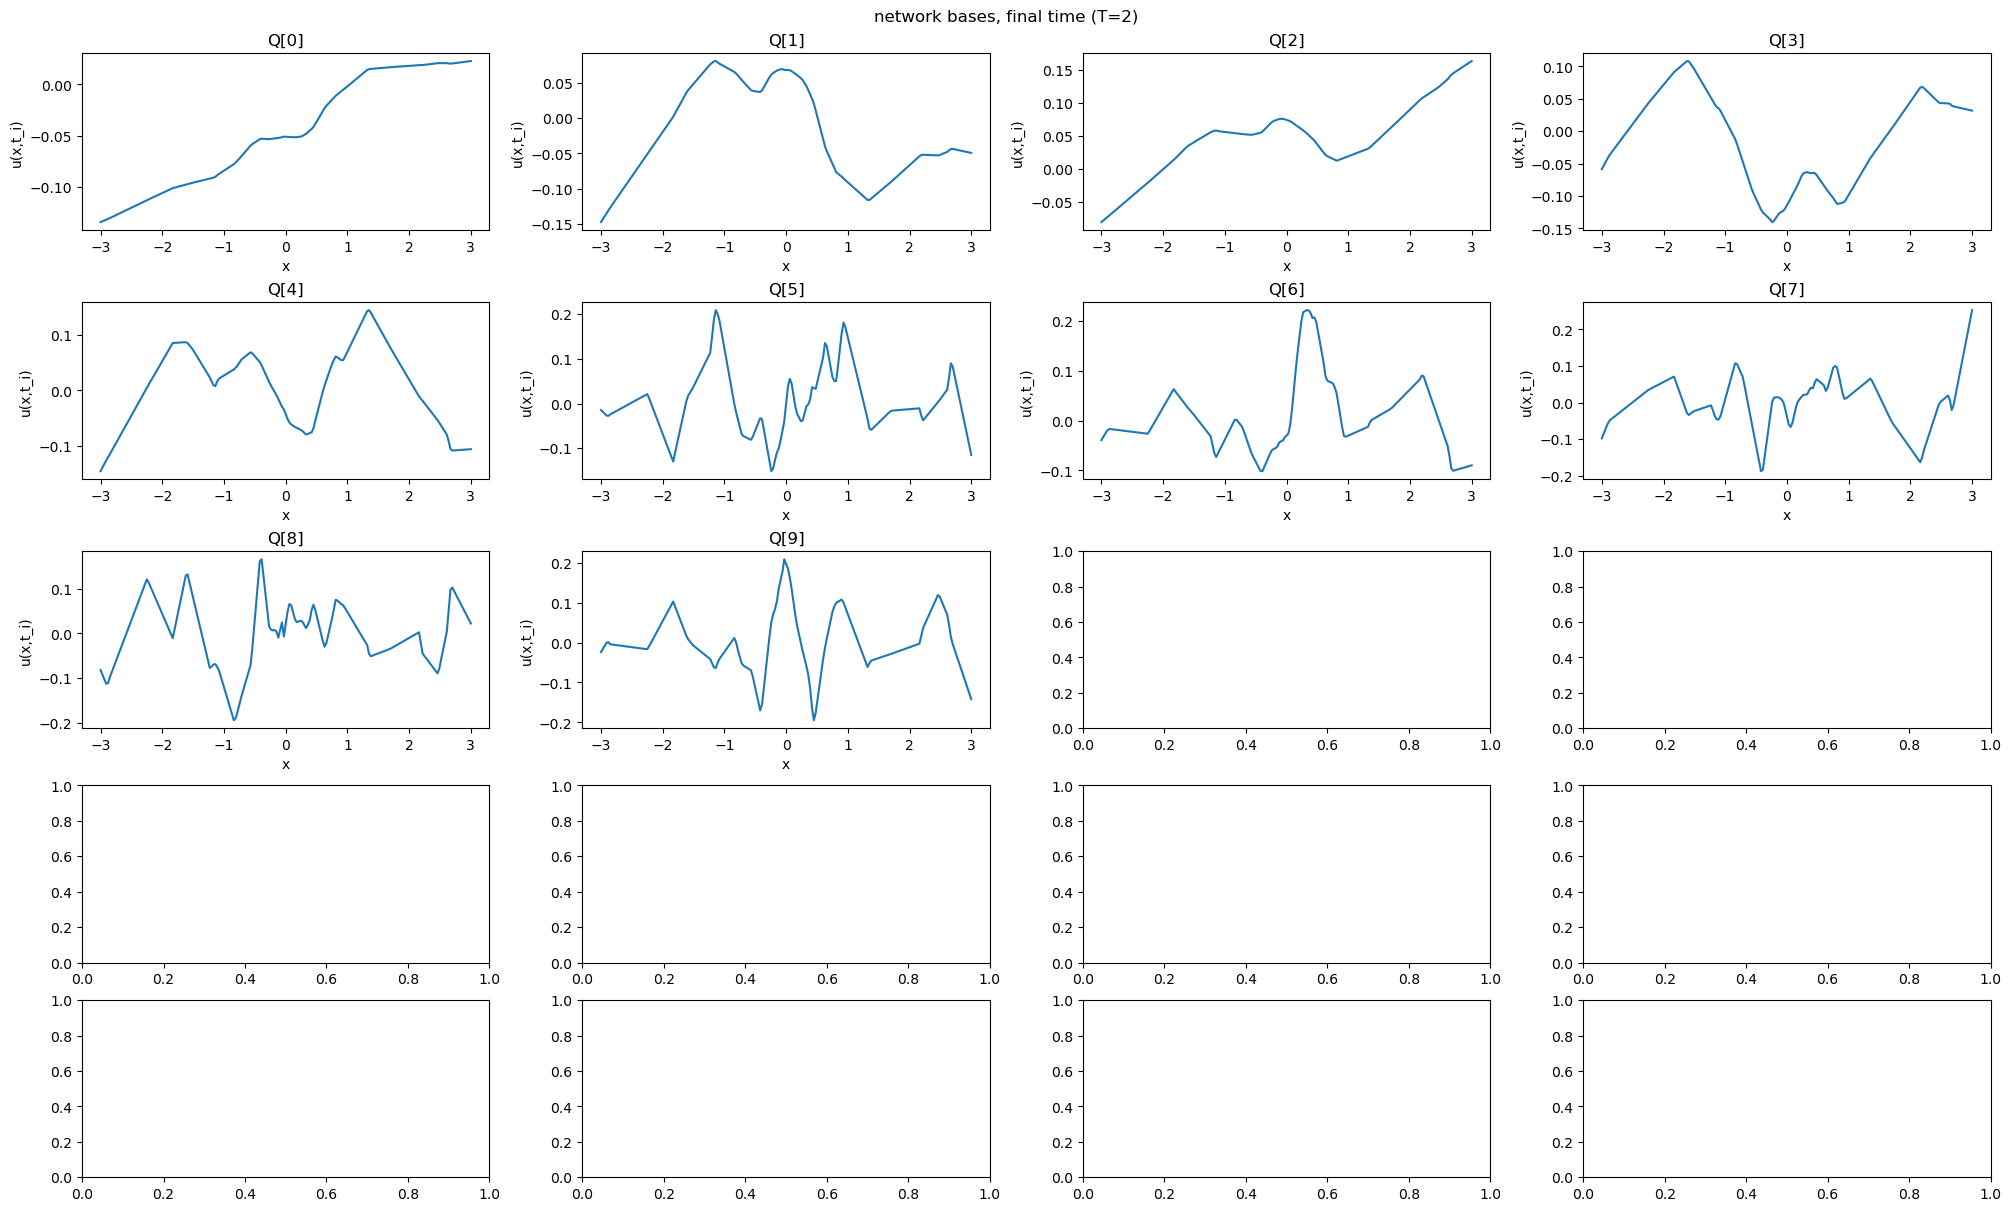

In [15]:
num_funcs = trunk_mat_at_i.shape[-1]
fig, axes = plt.subplots(5, 4, figsize=(20, 12), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        ax.plot(x_grid, Q[:,k])
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x,t_i)")
# plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
fig.suptitle("network bases, final time (T=2)")
plt.show()



In [16]:
Nt, Nx = len(t_grid), len(x_grid)
num_funcs = trunk_model(jnp.array([x_grid[0], t_grid[0]])).shape[-1]
Q_list = []

## REPLACE WITH SVD ORTHOGONALIZATION

for i, t in enumerate(t_grid):
    xx = jnp.stack([x_grid, jnp.full_like(x_grid, t)], axis=1)
    trunk_mat_t = np.array(jax.vmap(trunk_model)(xx))  # (Nx, num_funcs)
    Q_t, R_t = scipy.linalg.qr(trunk_mat_t, mode='economic')
    Q_list.append(Q_t)

Q_array = np.stack(Q_list, axis=0)  # shape (Nt, Nx, num_funcs)


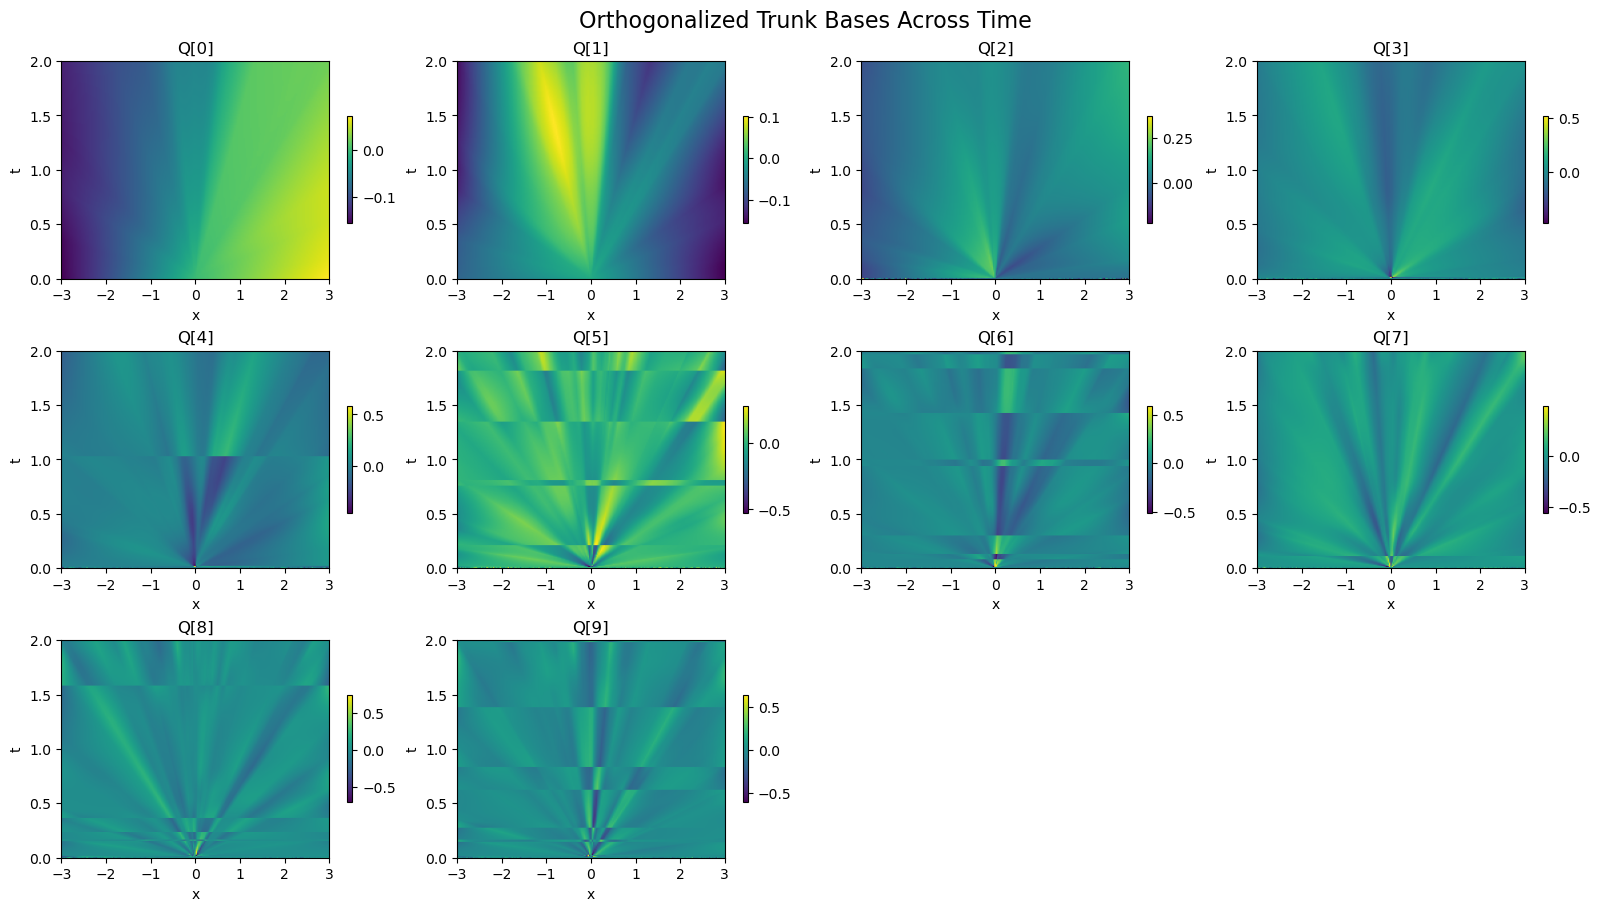

In [17]:

# choose subplot layout automatically (or manually override)
ncols = 4
nrows = int(np.ceil(num_funcs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), constrained_layout=True)

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_funcs:
        im = ax.imshow(
            Q_array[:, :, k:k+1],
            extent=(x_grid.min(), x_grid.max(), t_grid.min(), t_grid.max()),
            origin="lower",
            aspect="auto",
            cmap="viridis",
        )
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        fig.colorbar(im, ax=ax, fraction=0.02)
    else:
        ax.axis("off")

fig.suptitle("Orthogonalized Trunk Bases Across Time", fontsize=16)
plt.show()


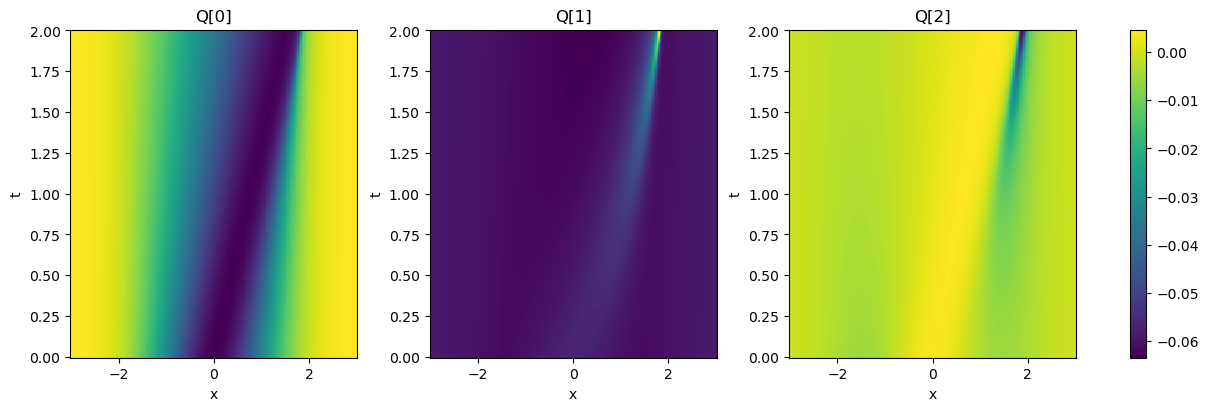

In [18]:
n_t, n_x = len(t_grid), len(x_grid)
Q,R = scipy.linalg.qr(ss_grid, mode = 'economic')
orth_funcs = Q.reshape(n_t, n_x, -1)
num_funcs = 3

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        im = ax.pcolormesh(x_grid, t_grid, orth_funcs[:,:,k], shading='auto')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.show()



## broader QR factorizations

In [50]:
# %%
Nt, Nx = len(t_grid), len(x_grid)
num_funcs = trunk_model(jnp.array([x_grid[0], t_grid[0]])).shape[-1]

block_size =45  # <-- orthogonalize every 5 time steps together
Q_array_broad = np.full((Nt, Nx, num_funcs), np.nan, dtype=np.float64)

for start in range(0, Nt, block_size):
    stop = min(start + block_size, Nt)
    ts = np.array(t_grid[start:stop])  # shape (B,)
    B = len(ts)                        # B = block length (<= block_size)

    # Build all (x, t) pairs in the block: ((B*Nx), 2)
    x_rep = np.repeat(np.asarray(x_grid)[None, :], B, axis=0)        # (B, Nx)
    t_rep = np.repeat(ts[:, None], Nx, axis=1)                        # (B, Nx)
    xt_block = np.stack([x_rep.ravel(), t_rep.ravel()], axis=1)       # (B*Nx, 2)

    # Evaluate trunk once for the whole block: (B*Nx, num_funcs)
    trunk_block = np.array(jax.vmap(trunk_model)(jnp.array(xt_block)))

    # Blockwise QR on the tall matrix
    # This yields an orthonormal basis across the whole block, then we slice it per time
    Q_block, R_block = scipy.linalg.qr(trunk_block, mode="economic")  # Q_block: (B*Nx, num_funcs)

    # Split Q_block back into per-time slices of shape (Nx, num_funcs)
    for i, t_idx in enumerate(range(start, stop)):
        sl = slice(i * Nx, (i + 1) * Nx)
        Q_array_broad[t_idx] = Q_block[sl, :]

# Q_array_broad now holds the orthonormalized trunk bases, with one QR per 5-time block


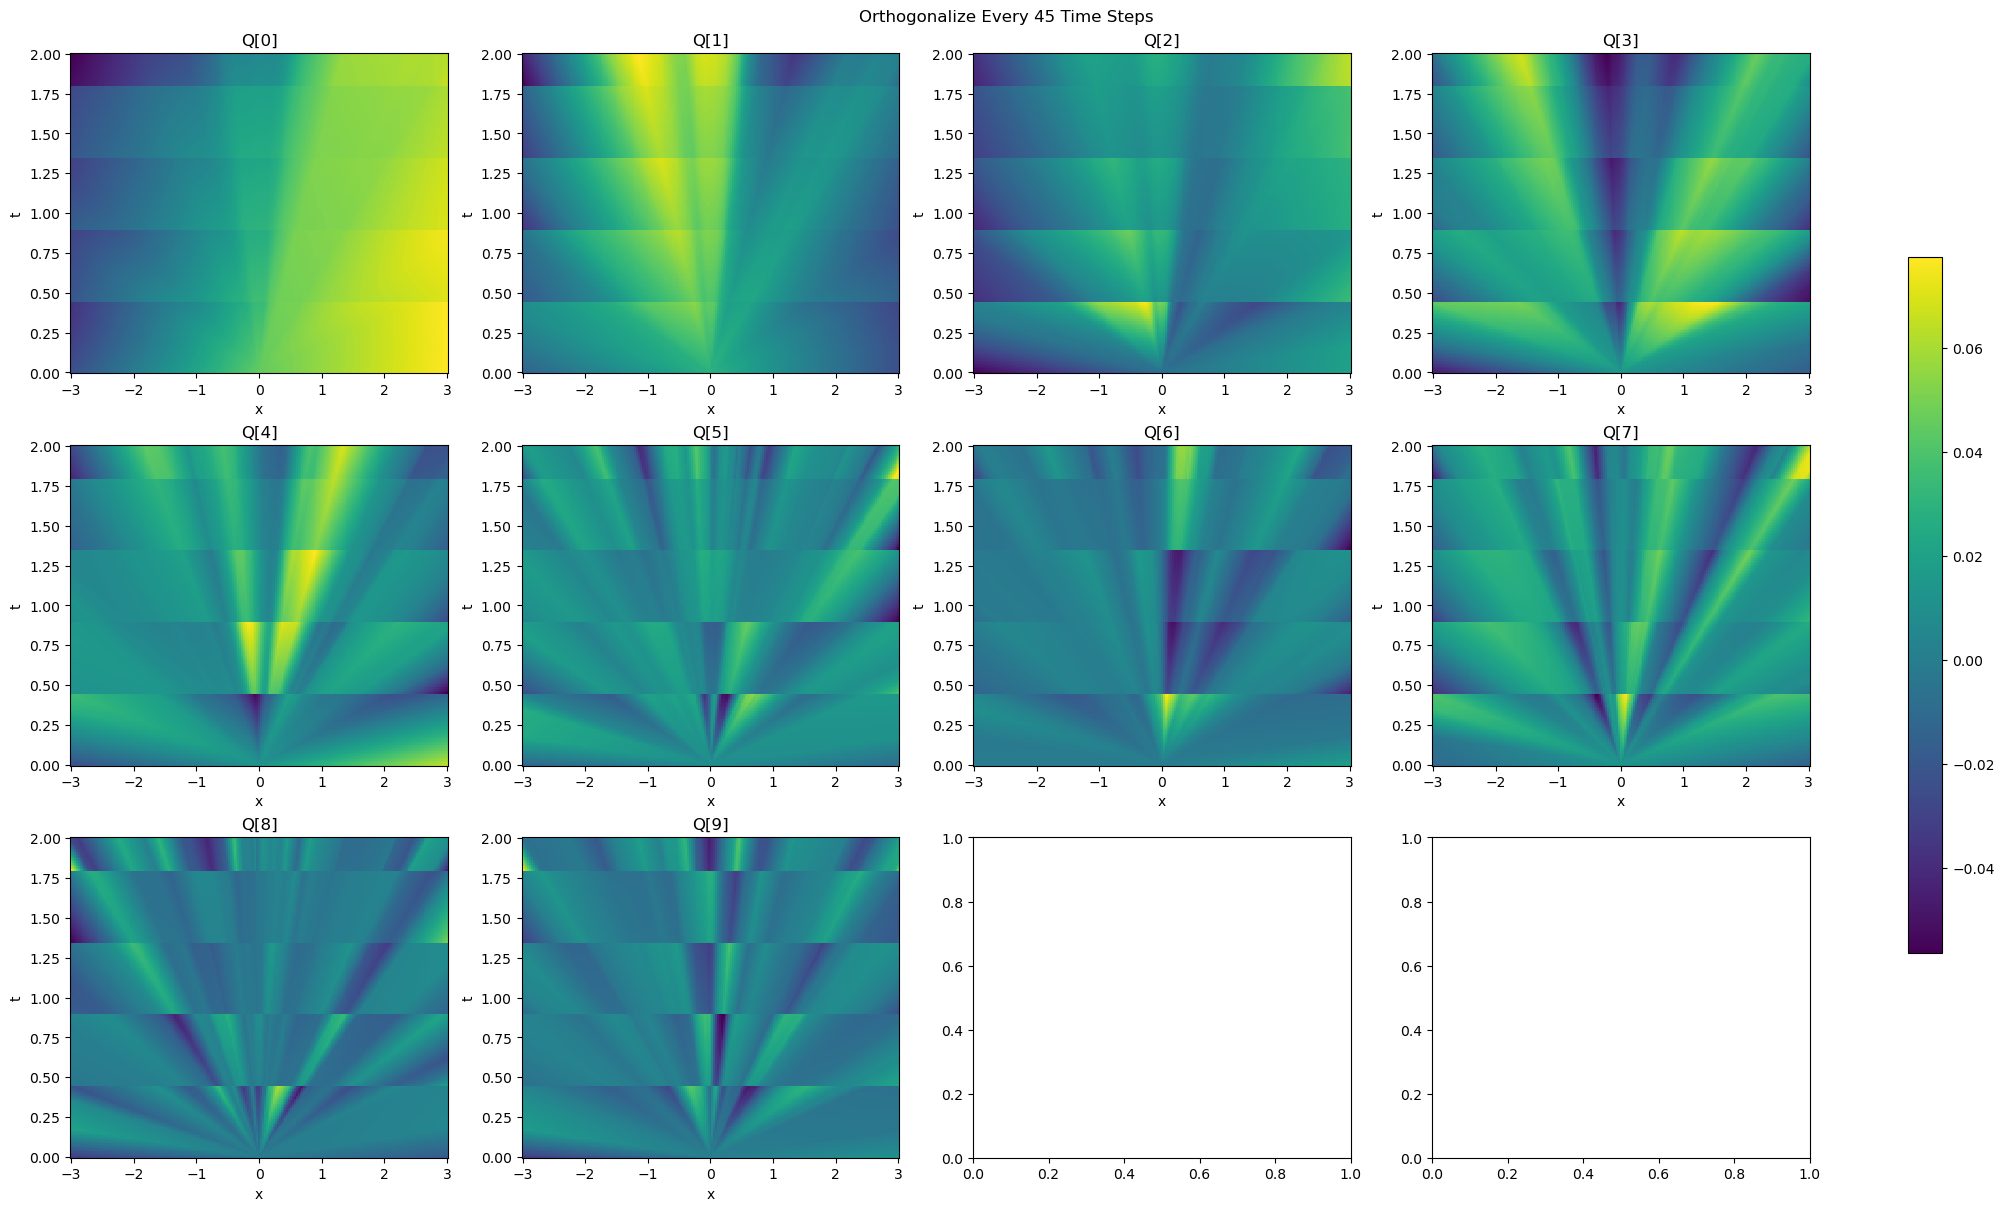

In [51]:
n_t, n_x = len(t_grid), len(x_grid)
Q,R = scipy.linalg.qr(ss_grid, mode = 'economic')
orth_funcs = Q_array_broad.reshape(n_t, n_x, -1)
num_funcs = 10

fig, axes = plt.subplots(3, 4, figsize=(20, 12), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        im = ax.pcolormesh(x_grid, t_grid, orth_funcs[:,:,k], shading='auto')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.suptitle(f"Orthogonalize Every {block_size} Time Steps")
plt.show()



## SVD Based Method

In [21]:
# calculate SVD of ss_grid (known solutions on domain)
U, s, Vh = scipy.linalg.svd(ss_grid)

In [22]:
errs = []
for truncated_rank in tqdm(np.arange(1, s.shape[0] + 1)):
    err = np.mean((ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])))**2)
    errs.append(err)



100%|██████████| 295/295 [00:09<00:00, 30.24it/s]


Text(0, 0.5, 'MSE')

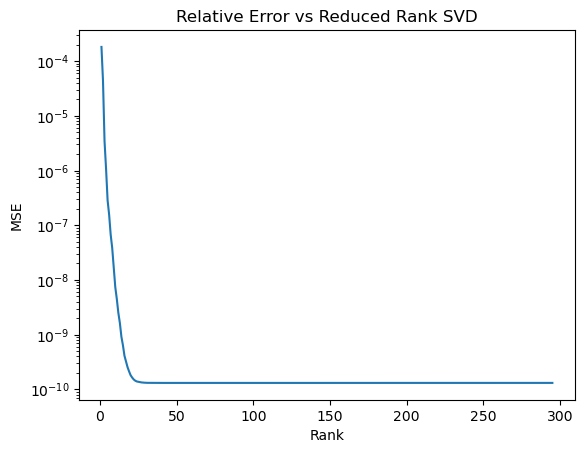

In [23]:
plt.semilogy(np.arange(1, s.shape[0] + 1), errs)
plt.title("Relative Error vs Reduced Rank SVD")
plt.xlabel("Rank")
plt.ylabel("MSE")

In [24]:
truncated_rank = 20
# err = np.linalg.norm(ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])) )
err = np.mean((ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])))**2)
print(f"err={err:.4e}")

err=1.8132e-10


In [25]:
deepOnet_err = np.mean(ss_grid - deeponet_step1(model, xt_grid))
print(f"deepOnet_err={deepOnet_err:.4e}")

deepOnet_err=-1.2683e-05


In [26]:
# s.shape
len(np.where(s > 1e-4)[0])

48

for each time step:
- get X,t at time step
- pass through trained model
- take QR of model (at time t) -> Q_k R_k
- generate set of basis functions Ψ_k at time t_k (Q) by inverting R_k

don't use np.linalg rank methods! 

compare SVD method vs network basis functions for accuracy and expressiveness